<center><img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px; margin-left: 10px; max-height: 250px;" /></center>

# 3.1 Data Processing

<img src="https://openeo.org/images/openeo_logo.png"
     alt="openEO logo"
     style="float: center; margin-right: 10px; max-height: 100px;"/>

## Snow Cover mapping with openEO Platform
<img src="https://openeo.cloud/wp-content/themes/openeo_platform/images/logo-pages.svg"
     alt="openEO Platform logo"
     style="float: center; margin-right: 10px; max-height: 100px;"/>

In this exercise we will build a complete EO workflow on a cloud platform; from data access to obtaining the result. In this example we will analyse snow cover in the Alps.

We are going to follow these steps in our analysis:

-   Load satellite collections
-   Specify the spatial, temporal extents and the features we are interested in
-   Process the satellite data to retrieve snow cover information
-   Aggregate information to get catchment statistics over time
-   Visualize and analyse the results

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

## Libraries

In [2]:
%%capture
pip install openeo rioxarray geopandas leafmap h5netcdf netcdf4 fiona

In [3]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

## Login
Connect to the copernicus dataspace ecosystem.

In [4]:
conn = openeo.connect('https://openeo.cloud/')

And login

In [5]:
conn.authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=AZQV-GRXD 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

Check if the login worked.

In [6]:
conn.describe_account()

{'info': {'oidc_userinfo': {'eduperson_entitlement': ['urn:mace:egi.eu:group:vo.openeo.cloud:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=vm_operator#aai.egi.eu',
    'urn:mace:egi.eu:res:ggus.eu',
    'urn:mace:egi.eu:res:gocdb#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=employee#aai.egi.eu',
    'urn:mace:egi.eu:group:dev.intertwin.eu:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=early_adopter#aai.egi.eu',
    'urn:mace:egi.eu:res:rcauth#aai.egi.eu'],
   'email': 'michele.claus@eurac.edu',
   'email_verified': True,
   'sub': '28860add33a3a705c0092d54ae94177752ba9fa4bf00a25b24864ea95b9e0025@egi.eu',
   'voperson_verified_email': ['michele.claus@eurac.edu']}},
 'name': 'michele.claus@eurac.edu',
 'user_id': '28860add33a3a705c0092d54ae94177752ba9fa4bf00a25b24864ea95b9e0025@egi.eu'}

## Region of Interest

Load the catchment area.

In [8]:
catchment_outline = gpd.read_file('../31_data/catchment_outline.geojson')

In [11]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('../31_data/catchment_outline.geojson', layer_name="catchment")
m

libpoppler.so.140: cannot open shared object file: No such file or directory
libpoppler.so.140: cannot open shared object file: No such file or directory
libpoppler.so.140: cannot open shared object file: No such file or directory
libpoppler.so.140: cannot open shared object file: No such file or directory


## Inspect Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available datasets.

In [12]:
conn.list_collections()

[{'description': 'Optical data collected with airborne drone platform, and processed with MapEO Water software v1 at VITO into turbidity. Turbidity indicates the relative opacity of the water column. It is an optical water property and a measure for the amount of light scattered by constituents in the water column. The higher the scattered light intensity, the higher the turbidity. Constituents that causes water to be turbid include clay, silt, very tiny inorganic and organic matter, algae, dissolved coloured organic compounds, plankton, and other microscopic organisms. Turbidity is expressed in Formazin Nephelometric Units (FNU, according to the ISO 7027 standard).',
  'extent': {'spatial': {'bbox': [[-180.0, -84.0, 180.0, 84.0]]},
   'temporal': {'interval': [['2018-02-01T00:00:00Z', None]]}},
  'id': 'MAPEO_WATER_TUR_V1',
  'keywords': ['Orthoimagery',
   'Water quality',
   'Turbidity',
   'Airborne drone data',
   'UAV',
   'RPAS',
   'Drone',
   'MicaSense',
   'DJI',
   'cm resolution',
   'super high resultion',
   'VITO'],
  'license': 'proprietary',
  'links': [{'href': 'https://services.terrascope.be/collectioncatalogue/srv/eng/catalog.search#/metadata/urn:eop:VITO:MAPEO_WATER_TUR_V1',
    'rel': 'alternate',
    'title': 'Collection Catalogue Entry'},
   {'href': 'https://services.terrascope.be/catalogue/catalogue/description.geojson?collection=urn:eop:VITO:MAPEO_WATER_TUR_V1',
    'rel': 'alternate',
    'title': 'OpenSearch entry point'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
    'rel': 'root'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections',
    'rel': 'parent'},
   {'href': 'https://openeocloud.vito.be/openeo/1.0.0/collections/MAPEO_WATER_TUR_V1',
    'rel': 'self'}],
  'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
  'stac_version': '0.9.0',
  'title': 'MapEO Water Turbidity (TUR) Products - V1'},
 {'description': 'The EU-DEM v1.1 is a resulting dataset of the EU-DEM v1.0 upgrade which enhances the correction of geo-positioning issues, reducing the number of artefacts, improving the vertical accuracy of EU-DEM using ICESat as reference and ensuring consistency with EU-Hydro public beta.EU-DEM v1.1 is available in Geotiff 32 bits format. It is a contiguous dataset divided into 1000 x 1000 km tiles, at 25m resolution with vertical accuracy: +/- 7 meters RMSE. The tiles have been grouped in big regions:EUDEM2_ASIA (Turkey); EUDEM2_ATLAN (Hondo and Fr_Islands);EUDEM2_BRITAIN (Thames, Shannon and Tweed); EUDEM2_EUROPE_1 (Duero, Ebro, Tajo, Guadalquivir and Jucar); EUDEM2_EUROPE_2 (Tirso, Mesima, Tevere and Po); EUDEM2_EUROPE_3 (Garonne, Rhone, Loire, Seine and western Rhine); EUDEM2_EUROPE_4 (Danube); EUDEM2_EUROPE_5 (Skjern, Nemunas, Vistula, Oder, Elbe and Eastern Rhine); EUDEM2_EUROPE_6 (Bulgaria and Pinios); EUDEM2_ICELAND (Iceland); EUDEM2_SCAND (Vorma, Gota, Angerman, Tana, Kemi and Neva); EUDEM2_SOUTH_AMERICA (Fr_Guiana). EU-DEM v1.1 upgrade was coordinated by the European Environment Agency (EEA) in the frame of the EU Copernicus programme.',
  'extent': {'spatial': {'bbox': [[-54.925613,
      -21.567515,
      93.178583,
      71.89922]]},
   'temporal': {'interval': [['2011-01-01T00:00:00Z',
      '2011-12-31T00:00:00Z']]}},
  'id': 'COP_DEM_EU_25M',
  'keywords': ['VITO',
   'TERRASCOPE',
   'COPERNICUS',
   'ESA',
   'Radar',
   'Elevation',
   'DEM',
   'EUROPE'],
  'license': 'proprietary',
  'links': [{'href': 'https://services.terrascope.be/collectioncatalogue/srv/eng/catalog.search#/metadata/urn:eop:VITO:VITO:COP_DEM_EU_25M',
    'rel': 'alternate',
    'title': 'Collection Catalogue Entry'},
   {'href': 'https://land.copernicus.eu/user-corner/technical-library/eu-dem-v1-1-user-guide',
    'rel': 'alternate',
    'title': 'Online User Documentation'},
   {'href': 'https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1/view',
    'rel': 'alter

We want to use the Sentinel-2 L2A product. It's name is `'SENTINEL2_L2A'`. 

We get the metadata for this collection as follows.

In [13]:
conn.describe_collection("SENTINEL2_L2A")

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'AOT',
    'SCL',
    'SNW',
    'CLD',
    'CLP',
    'CLM',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean',
    'dataMask',
    'relativeAzimuthAngles',
    'viewZenithAngles']},
  't': {'extent': ['2015-07-06T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': '[Sentinel-2 Level 2A](https://docs.terrascope.be/#/DataProducts/Sentinel-2/Level2A/Level2A) product, processed from L1C by Sen2Cor. \n Use the [Terrascope viewer](https://viewer.terrascope.be/?language=nl&bbox=0.9339867511378304,50.14520994379217,6.207424251137831,51.77292299745045&overlay=false&bgLayer=MapBox&date=2019-02-25T03:17:15.000Z&layer=CGS_S2_RADIOMETRY) to explore the data. \n\n ',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83], [-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-06T00:00:00Z', None],
    ['2016-11-01T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['VITO',
  'TERRASCOPE',
  'COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license'},
  {'href': 'https://services.terrascope.be/catalogue/description?collection=urn:eop:VITO:TERRASCOPE_S2_TOC_V2',
   'rel': 'alternate'},
  {'href': 'https://viewer.terrascope.be/?language=nl&bbox=0.9339867511378304,50.14520994379217,6.207424251137831,51.77292299745045&overlay=false&bgLayer=MapBox&date=2019-02-25T03:17:15.000Z&layer=CGS_S2_RADIOMETRY',
   'rel': 'alternate'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'CGS_S2_RADIOMETRY'},
  {'href': 'https://services.sentinel-hub.com/ogc/wmts/7d34803f-511c-4caf-9438-6d72f32c8174',
   'rel': 'wmts',
   'wmts:dimens

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018.

In [14]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

In [15]:
from openeo.processes import lte
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = ["2022-02-01", "2022-06-30"]
bands           = ['B03', 'B11']
properties={"eo:cloud_cover": lambda x: lte(x, 90)}

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

In [16]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent,
                          bands=bands,
                          temporal_extent=temporal_extent,
                          properties=properties)

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the cloud mask (CLM). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [17]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a timeseries of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.42 on the NDSI. This gives us a binary snow map.

In [18]:
snowmap = ( ndsi > 0.42 ) * 1.0
snowmap

### Creating a cloud mask
We are going to use "SCL" band for creating a cloud mask and then applying it to the NDSI. 
`8 = cloud medium probability`, `9 = cloud high probability`, `3 = cloud shadow`

Here is more information on the Scene Classification https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview

| Value        | Label    |
|--------------|-----------|
| 0	    | NO_DATA                  |
| 1	    | SATURATED_OR_DEFECTIVE   |
| 2	    | CAST_SHADOWS             |
| 3	    | CLOUD_SHADOWS            |
| 4	    | VEGETATION               |
| 5	    | NOT_VEGETATED            |
| 6	    | WATER 	    	       |
| 7	    | UNCLASSIFIED 	           |
| 8	    | CLOUD_MEDIUM_PROBABILITY |
| 9	    | CLOUD_HIGH_PROBABILITY   |
| 10	| THIN_CIRRUS              |
| 11	| SNOW or ICE              |

In [19]:
scl_cube =conn.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    bands=["SCL"],
    temporal_extent=temporal_extent,
    max_cloud_cover=90,
    
)

In [20]:
scl_band = scl_cube.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

The SCL layer has a ground sample distance of 20 meter while the other bands have 10 meter GSD

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, 2 = cloud

In [21]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Mask Polygon: From Bounding Box to Shape
Filter to the exact outline of the catchment: this should mask out the pixels outside of the catchment.

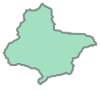

In [22]:
catchment_outline['geometry'][0]

In [23]:
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

#### Visualize one time step of the timeseries
Let's download the whole image time series as a netcdf file to have a look how our first results look like

In [24]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2022-02-10', '2022-02-12')
snowmap_cloudfree_1d.download('results/snowmap_cloudfree_1d.nc')

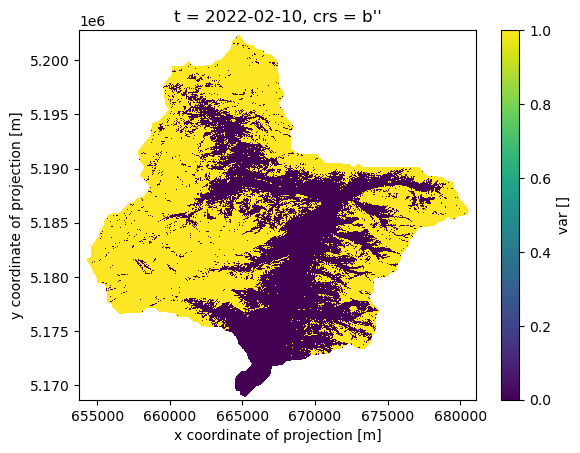

In [25]:
xr.open_dataarray('results/snowmap_cloudfree_1d.nc',decode_coords="all")[0].plot.imshow()

## Calculate Catchment Statistics

We are looking at a region over time. We need to make sure that the information content meets our expected quality. Therefore, we calculate the **cloud percentage** for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 25% will be discarded.

Ultimately we are interested in the **snow covered area (SCA)** within the catchment. We count all snow covered pixels within the catchment for each time step. Multiplied by the pixel size that would be the snow covered area. Divided the pixel count by the total number of pixels in the catchment is the percentage of pixels covered with snow. We will use this number.

Get number of pixels in catchment: total, clouds, snow.

In [26]:
# number of all pixels
n_catchment = ((snowmap_cloudfree > -1) * 1.0).add_dimension(name="bands",type="bands",label="n_catchment")

# number of cloud pixels (no function needed, mask already created before)
n_cloud = cloud_mask.add_dimension(name="bands",type="bands",label="n_cloud")

# number of snow pixels
n_snow = ((snowmap_cloudfree == 1) * 1.0).add_dimension(name="bands",type="bands",label="n_snow")

# combine the binary data cubes into one data cube
n_catchment_cloud_snow = n_catchment.merge_cubes(n_cloud).merge_cubes(n_snow)

# aggregate to catchment
n_pixels = n_catchment_cloud_snow.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum')
n_pixels

Create batch job to start processing on the backend.

In [27]:
# Create a batch job
n_pixels_json = n_pixels.save_result(format="JSON")
job = n_pixels_json.create_job(title="n_pixels_json")
job.start_job()

<BatchJob job_id='vito-j-25061012100049f090d0c560ed8b62ff'>

In [29]:
job.status()

'finished'

In [30]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("results_openeo_platform/")

Load the result. It contains the number of pixels in the catchment, clouds and snow.

We can calculate the percentages of cloud and snow pixels in the catchment.

In [31]:
with open("results_openeo_platform/timeseries.json","r") as file:
    n_pixels_json = json.load(file)

In [32]:
# check the first 5 entries
list(n_pixels_json.items())[:3] # careful unsorted dates due to JSON format

[('2022-05-18T00:00:00Z', [[4201607, 2116387, 176298]]),
 ('2022-05-16T00:00:00Z', [[4201607, 3180590, 127431]]),
 ('2022-05-31T00:00:00Z', [[4201607, 3342522, 4679]])]

In [33]:
# Create a Pandas DataFrame to contain the values
dates = [k for k in n_pixels_json]
n_catchment_vals = [n_pixels_json[k][0][0] for k in n_pixels_json]
n_cloud_vals = [n_pixels_json[k][0][1] for k in n_pixels_json]
n_snow_vals = [n_pixels_json[k][0][2] for k in n_pixels_json]

data = {
        "time":pd.to_datetime(dates),
        "n_catchment_vals":n_catchment_vals,
        "n_cloud_vals":n_cloud_vals,
        "n_snow_vals":n_snow_vals
       }
df = pd.DataFrame(data=data).set_index("time")
# Sort the values by date
df = df.sort_values(axis=0,by="time")
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals
time,,,
2022-02-05 00:00:00+00:00,4201607,857590,2138314
2022-02-07 00:00:00+00:00,4166981,3974004,139642
2022-02-10 00:00:00+00:00,4201607,0,2456725


Divide the number of cloudy pixels by the number of total pixels = cloud percentage

In [34]:
perc_cloud = df["n_cloud_vals"].values / df["n_catchment_vals"].values * 100
df["perc_cloud"] = perc_cloud
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud
time,,,,
2022-02-05 00:00:00+00:00,4201607,857590,2138314,20.411000
2022-02-07 00:00:00+00:00,4166981,3974004,139642,95.368901
2022-02-10 00:00:00+00:00,4201607,0,2456725,0.000000


Plot the timeseries and the cloud threshold of 25%. If the cloud cover is higher the timestep will be excluded later on.

Plot the **cloud percentage** with the threshold.

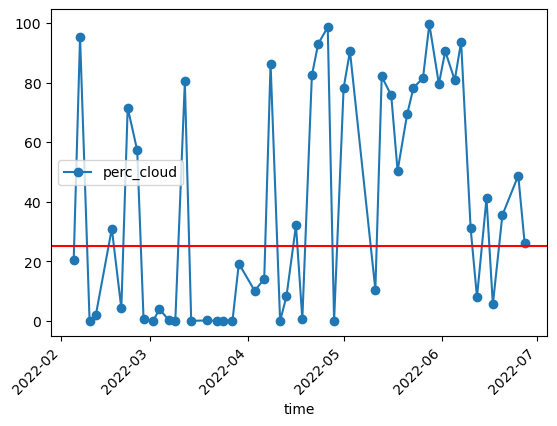

In [35]:
df.plot(y="perc_cloud",rot=45,kind="line",marker='o')
plt.axhline(y = 25, color = "r", linestyle = "-")
plt.show()

Divide the number of snow pixels by the number of total pixels = snow percentage

In [36]:
perc_snow = df["n_snow_vals"].values / df["n_catchment_vals"].values * 100
df["perc_snow"] = perc_snow
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud,perc_snow
time,,,,,
2022-02-05 00:00:00+00:00,4201607,857590,2138314,20.411000,50.892766
2022-02-07 00:00:00+00:00,4166981,3974004,139642,95.368901,3.351155
2022-02-10 00:00:00+00:00,4201607,0,2456725,0.000000,58.471080


Plot the **unfiltered snow percentage**

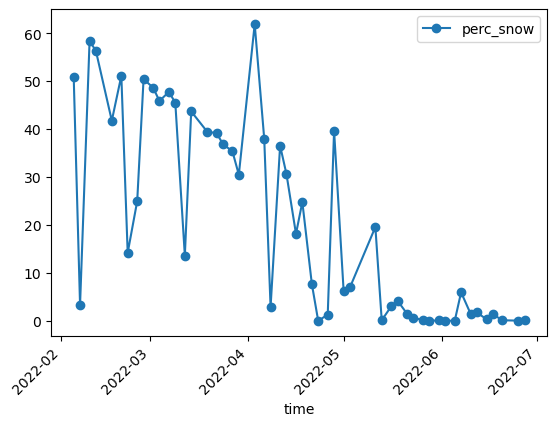

In [37]:
df.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

Keep only the dates with cloud coverage less than the threshold

In [38]:
df_filtered = df.loc[df["perc_cloud"]<25]

Plot the **cloud filtered snow percentage**

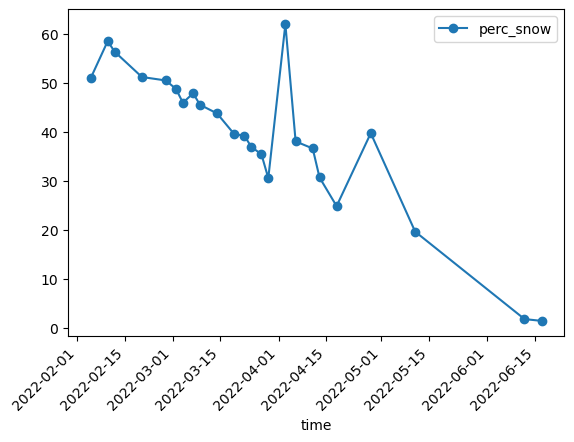

In [39]:
df_filtered.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

Save the **cloud filtered snow percentage**

In [40]:
df_filtered.to_csv("results_openeo_platform/filtered_snow_perc.csv")